In [ ]:
#Phantom_SUV_Checker_verβ1(E):開発中のコード残す
#Phantom_SUV_Checker_verβ2(E):暫定完成版

In [1]:
import pydicom
import tkinter as tk
import PIL
from PIL import ImageTk
from PIL import Image

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import tifffile



In [50]:
#必要なpath
PH2mm_PATH=r"C:\Users\shink\seki\PT_brain\WB138"

In [51]:
def count_to_SUV(dcmPATH):
    ds = pydicom.read_file(dcmPATH)
    #ACT=Acquisition_Time
    ACT=ds[0x0008, 0x0032].value

    #RST=Radiopharmaceutical Start Time
    RST=ds[0x0054, 0x0016].value[0][0x0018, 0x1072].value

    DURATION=(int(ACT[:2])-int(RST[:2]))*3600+(int(ACT[2:4])-int(RST[2:4]))*60+(int(ACT[4:6])-int(RST[4:6]))
    weight = ds[0x0010,0x1030].value
    duration = DURATION   #薬剤投与から撮像までの時間は60分とした
    half_life = ds[0x0054,0x0016].value[0][0x0018,0x1075].value
    total_dose = ds[0x0054,0x0016].value[0][0x0018,0x1074].value

    if weight ==0:
        s_factor="null"
    else:
        dose=total_dose*(1/2)**(duration/half_life)
        s_factor=dose/(weight*1000)

    return s_factor

In [52]:
#class SUV_from_DICOM(self):

#dicomPATHの一覧を作成
def make_dicompath(MAIN_PATH):
    d_list=os.listdir(MAIN_PATH)
    d_path_list=[]
    for d_PATH in d_list:
        d_path_list.append(os.path.join(MAIN_PATH,d_PATH))
    return d_path_list
    
#dicomPATHをスライスの順に並び変え
def sort_dicompath(d_path_list):
    d_POS={}#スライス位置とpathの対応
    for d_PATH in d_path_list:
        d=pydicom.read_file(d_PATH)
        d_POS[d[0x0020,0x1041].value]=d_PATH
    d_POS_2=sorted(d_POS.items(),reverse=True)
    print(d_POS_2[0][1])
    d_path_list_sort=[d_POS_2[i][1] for i in range(len(d_POS_2))]
    return d_path_list_sort

#dicomPATHからSUV画像を読み込む
def tif_to_img(d_path_list):
    imgsPT=[]
    for d_PATH in d_path_list:
        img=tifffile.imread(d_PATH)

        imgsPT.append(img)
    return np.array(imgsPT)

#axial画像からcoronal,sagittal画像を生成
def make_axcrsg_imgs(imgs_axl):
    imgs_sag=[]
    imgs_cor=[]

    #coronal
    imgs_cor=imgs_axl.transpose([1,0,2])

    #sagittal
    imgs_sag=imgs_axl.transpose([2,1,0])

    #showimg
    fig=plt.figure(figsize=(8,8))

    ax1=fig.add_subplot(2,2,1)
    mip_axl=imgs_axl.max(axis=0)
    ax1.imshow(mip_axl,cmap="jet",vmax=8)
    ax1.set_aspect("equal")
    ax1.axis("off")
    ax2=fig.add_subplot(2,2,3)
    mip_cor=imgs_cor.max(axis=0)
    ax2.imshow(mip_cor,cmap="jet",vmax=8)
    ax2.set_aspect("equal")
    ax2.axis("off")

    ax3=fig.add_subplot(2,2,2)
    mip_sag=imgs_sag.max(axis=0)
    ax3.imshow(mip_sag,cmap="jet",vmax=8)
    ax3.set_aspect("equal")
    ax3.axis("off")
    return imgs_cor,imgs_sag

2mm shape: (964, 576, 576) maxSUV: 41.000504


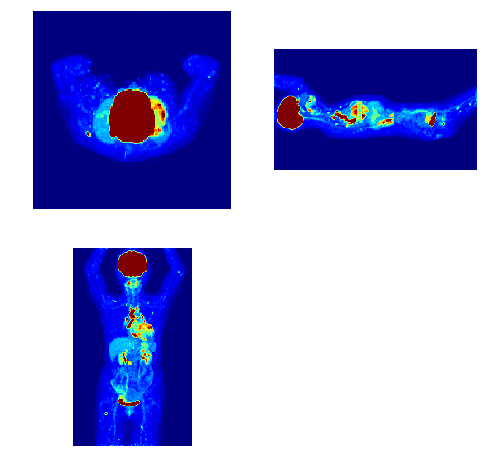

In [53]:
#load_2mm
d_path_list=make_dicompath(PH2mm_PATH)
# d_path_list=sort_dicompath(d_path_list)
imgs2mm=tif_to_img(d_path_list).repeat(4,axis=0).repeat(4,axis=1).repeat(4,axis=2)
imgs2mm_cor,imgs2mm_sag=make_axcrsg_imgs(imgs2mm)
print("2mm","shape:",imgs2mm.shape,"maxSUV:",imgs2mm.max())

In [54]:
#各ROIの初期座標
xR=[[i*10+1,(i+1)*10] for i in range(6) ]
print("xR",xR)
yR=[[0,10] for i in range(6) ]
print("yR",yR)
zR=[[i*10+1,(i+1)*10] for i in range(6) ]
print("zR",zR)

xR [[1, 10], [11, 20], [21, 30], [31, 40], [41, 50], [51, 60]]
yR [[0, 10], [0, 10], [0, 10], [0, 10], [0, 10], [0, 10]]
zR [[1, 10], [11, 20], [21, 30], [31, 40], [41, 50], [51, 60]]


In [55]:
from tkinter import *
from tkinter import ttk

#リアルタイムで画像を更新
def img1_change(val):
    global img1,val1
    val1=val
    img1 = ImageTk.PhotoImage(PIL.Image.fromarray(PH_axi[int(val)]))
    #print(val)
    canvas1.itemconfig(image_on_canvas1,image=img1)

def img2_change(val):
    global img2,val2
    val2=val
    img2 = ImageTk.PhotoImage(PIL.Image.fromarray(PH_col[int(val)]))
    #print(val)
    canvas2.itemconfig(image_on_canvas2,image=img2)
    canvas1.coords("col",0, val2, len(PH_sag)-1, val2)

def img3_change(val):
    global img3,val3
    val3=val
    img3 = ImageTk.PhotoImage(PIL.Image.fromarray(PH_sag[int(val)]))
    #print(val)
    canvas3.itemconfig(image_on_canvas3,image=img3)
    canvas1.coords("sag",val3, 0, val3, len(PH_col)-1)
    
    
#クリックした点をROIの始点にする
def press_1(event):
    global xR,yR,zR
    
    x1 = event.x
    y1 = event.y
    xR[nR-1][0]=x1
    yR[nR-1][0]=y1
    canvas1.coords("rect_a"+str(nR),xR[nR-1][0],yR[nR-1][0],xR[nR-1][1],yR[nR-1][1])
    canvas2.coords("rect_c"+str(nR),xR[nR-1][0],zR[nR-1][0],xR[nR-1][1],zR[nR-1][1])
    canvas3.coords("rect_s"+str(nR),yR[nR-1][0],zR[nR-1][0],yR[nR-1][1],zR[nR-1][1])

def press_2(event):
    global xR,yR,zR
    
    x1 = event.x
    z1 = event.y
    xR[nR-1][0]=x1
    zR[nR-1][0]=z1
    canvas1.coords("rect_a"+str(nR),xR[nR-1][0],yR[nR-1][0],xR[nR-1][1],yR[nR-1][1])
    canvas2.coords("rect_c"+str(nR),xR[nR-1][0],zR[nR-1][0],xR[nR-1][1],zR[nR-1][1])
    canvas3.coords("rect_s"+str(nR),yR[nR-1][0],zR[nR-1][0],yR[nR-1][1],zR[nR-1][1])
    
def drag_1(event):
    global xR,yR,zR

    x2 = event.x
    y2 = event.y
    xR[nR-1][1]=x2
    yR[nR-1][1]=y2
    canvas1.coords("rect_a"+str(nR),xR[nR-1][0],yR[nR-1][0],xR[nR-1][1],yR[nR-1][1])
    canvas2.coords("rect_c"+str(nR),xR[nR-1][0],zR[nR-1][0],xR[nR-1][1],zR[nR-1][1])
    canvas3.coords("rect_s"+str(nR),yR[nR-1][0],zR[nR-1][0],yR[nR-1][1],zR[nR-1][1])
def drag_2(event):
    global xR,yR,zR

    x2 = event.x
    z2 = event.y
    xR[nR-1][1]=x2
    zR[nR-1][1]=z2
    canvas1.coords("rect_a"+str(nR),xR[nR-1][0],yR[nR-1][0],xR[nR-1][1],yR[nR-1][1])
    canvas2.coords("rect_c"+str(nR),xR[nR-1][0],zR[nR-1][0],xR[nR-1][1],zR[nR-1][1])
    canvas3.coords("rect_s"+str(nR),yR[nR-1][0],zR[nR-1][0],yR[nR-1][1],zR[nR-1][1])
    

def ROI_select():
    global text
    TextUpdater(1,7)
    ROI_xyz=[["ROI_"+str(i+1),C_code[i],xR[i][0],xR[i][1],yR[i][0],yR[i][1],zR[i][0],zR[i][1]] for i in range(6)]

    for i in range(len(ROI_xyz)):
        text+=str(ROI_xyz[i])+"\n"
        if i==len(ROI_xyz):
            text+=str(ROI_xyz[i])
    print(repr(text))
    text_widget.insert("2.0",text)

def text_clear():
    text_widget.delete("1.0","end")
#nR:選択中のROI番号
nR=1
#textを行を変えずに更新
#最初の1行だけ更新:(d1,d2)=0,1
def TextUpdater(d1,d2):
    global text
    text=str("")
    #全取得
    text_g = text_widget.get('1.0', 'end')
    #全削除
    text_widget.delete("1.0","end")
    
    #開業で分割してリスト化
    text1=text_g.split('\n')
    print("text1",text1,repr(text1[-1]))
    #指定した範囲を消す
    del text1[d1:d2]
    print("text1",text1,repr(text1[-1]))
    text1=[s for s in text1 if s != '']
    print("text1",text1)

    #print("text12",text1)

    for i in range(len(text1)):
        text+=str(text1[i])
        print(i,repr(text1[i]))
        if not i==len(text1):
            text+="\n"
            


#ROI 1～6のコマンド
def RB1():
    global nR,text
    nR=1
    TextUpdater(0,1)
    text="ROI1_is_selected\n"+text
    print(repr(text))
    text_widget.insert("1.0",text)
def RB2():
    global nR,text
    nR=2
    TextUpdater(0,1)
    text="ROI2_is_selected\n"+text
    print(repr(text))
    text_widget.insert("1.0",text)
def RB3():
    global nR,text
    nR=3
    TextUpdater(0,1)
    text="ROI3_is_selected\n"+text
    print(repr(text))
    text_widget.insert("1.0",text)
def RB4():
    global nR,text
    nR=4
    TextUpdater(0,1)
    text="ROI4_is_selected\n"+text
    print(repr(text))
    text_widget.insert("1.0",text)
def RB5():
    global nR,text
    nR=5
    TextUpdater(0,1)
    text="ROI5_is_selected\n"+text
    print(repr(text))
    text_widget.insert("1.0",text)
def RB6():
    global nR,text
    nR=6
    TextUpdater(0,1)
    text="ROI6_is_selected\n"+text
    print(repr(text))
    text_widget.insert("1.0",text)


#テキストを取得→1行目を削除→有効なROIを1行目に追加→テキストに出力
# def RB1():
#     text0 = text_widget.get('1.0', 'end')
#     text_widget.delete("1.0","end")
    
#     text1=text0.split('\n')
#     print("text1",text1)
#     text1=text1[1:-1]
#     print("text12",text1)

#     for i in range(len(text1)):
#         print(i,len(text1)-i-1)
#         text_widget.insert("1.0",text1[len(text1)-i-1])

#         if not i ==len(text1):
#             text_widget.insert("1.0","\n")
#     text_widget.insert("1.0","ROI1_is_selected")


RB=[RB1,RB2,RB3,RB4,RB5,RB6]

#色のリスト
C_code=['red', 'green', 'blue', 'cyan', 'yellow', 'magenta']
print(C_code)

['red', 'green', 'blue', 'cyan', 'yellow', 'magenta']


In [56]:
#ROIの座標一覧表示（出力をコピペでセーブ可能）
ROI_xyz=[["ROI_"+str(i+1),C_code[i],xR[i][0],xR[i][1],yR[i][0],yR[i][1],zR[i][0],zR[i][1]] for i in range(6)]
print("ROI      Color    x1  x2   y1  y2   z1  z2")
for i in range(len(ROI_xyz)):
    print(ROI_xyz[i])


ROI      Color    x1  x2   y1  y2   z1  z2
['ROI_1', 'red', 1, 10, 0, 10, 1, 10]
['ROI_2', 'green', 11, 20, 0, 10, 11, 20]
['ROI_3', 'blue', 21, 30, 0, 10, 21, 30]
['ROI_4', 'cyan', 31, 40, 0, 10, 31, 40]
['ROI_5', 'yellow', 41, 50, 0, 10, 41, 50]
['ROI_6', 'magenta', 51, 60, 0, 10, 51, 60]


In [ ]:
#frame12345
PH_axi=imgs2mm/8*255
PH_col=imgs2mm_cor/8*255
PH_sag=imgs2mm_sag.transpose(0,2,1)/8*255
x=PH_axi.shape[2]
y=PH_axi.shape[1]
# windowを描画
root = tk.Tk()
# windowサイズを変更
root.geometry("1850x850")
# windowタイトルを設定
root.title("NEMA_PHANTOM")

#直方体を作る際の頂点の座標を表すグローバル変数
#n:ROIの数
n=6


val1=int(len(PH_axi)/2)
val2=int(len(PH_col)/2)
val3=int(len(PH_sag)/2)
#アキシャル画像
img1 = ImageTk.PhotoImage(PIL.Image.fromarray(PH_axi[int(val1)]))
frame1 = tk.Frame(root,width=700,height=1000)
canvas1 = tk.Canvas(frame1,width=x,height=y)
print(x,y)
image_on_canvas1=canvas1.create_image(0,0,image=img1,tags="img1",anchor="nw")
#アキシャル上でスライス位置表示
canvas1.create_line(0, val2, len(PH_sag)-1, val2, fill='blue',tags="col")
canvas1.create_line(val3, 0, val3, len(PH_col)-1, fill='green',tags="sag")
#ROI長方形x6
for i in range(6):
    canvas1.create_rectangle(xR[i][0],yR[i][0],xR[i][1],yR[i][1],outline=C_code[i],tags="rect_a"+str(i+1))


#スケールバー
sc1 = tk.Scale(frame1,orient=tk.HORIZONTAL,length=250,from_=0,to=len(PH_axi)-1,command = img1_change)
canvas1.tag_bind("img1","<ButtonPress-1>",press_1)
canvas1.tag_bind("img1","<B1-Motion>",drag_1)
frame1.grid(row=0,column=0)
canvas1.grid(row=0,column=0)
sc1.grid(row=1)

#コロナル画像
img2 = ImageTk.PhotoImage(PIL.Image.fromarray(PH_col[int(val2)]))
frame2 = tk.Frame(root,width=700,height=1000,bg="Green")
canvas2 = tk.Canvas(frame2,width=x,height=y)
image_on_canvas2=canvas2.create_image(0,0,image=img2,tags="img2",anchor="nw")
#ROI長方形x6
for i in range(6):
    canvas2.create_rectangle(xR[i][0],zR[i][0],xR[i][1],zR[i][1],outline=C_code[i],tags="rect_c"+str(i+1))

sc2 = tk.Scale(frame2,orient=tk.HORIZONTAL,length=250,from_=0,to=len(PH_col)-1,command = img2_change)
canvas2.tag_bind("img2","<ButtonPress-1>",press_2)
canvas2.tag_bind("img2","<B1-Motion>",drag_2)
frame2.grid(row=0,column=1)
canvas2.grid(row=0,column=0)
sc2.grid(row=1)

#サジタル画像
img3 = ImageTk.PhotoImage(PIL.Image.fromarray(PH_sag[int(val3)]))
frame3 = tk.Frame(root,width=1000,height=1000)
canvas3 = tk.Canvas(frame3,width=x,height=y)
image_on_canvas3=canvas3.create_image(0,0,image=img3,tags="img3",anchor="nw")
#ROI長方形
for i in range(6):
    canvas3.create_rectangle(yR[i][0],zR[i][0],yR[i][1],zR[i][1],outline=C_code[i],tags="rect_s"+str(i+1))

sc3 = tk.Scale(frame3,orient=tk.HORIZONTAL,length=250,from_=0,to=len(PH_sag)-1,command = img3_change)
frame3.grid(row=0,column=2)
canvas3.grid(row=0,column=0)
sc3.grid(row=1)

#統計量計算のボタン、信号の閾値を指定するscaleをつける
frame4 = tk.Frame(root,width=250,height=500)
frame4.grid(row=0,column=3)
btnR=[]
for i in range(n):
    name="ROI"+str(i+1)
    btn = Button(frame4,text=name,command=RB[i])
    btn.grid(row=i,column=0)

    btnR.append(btn)
    #print(btnR)
btn = tk.Button(frame4,text="xyz",command=ROI_select)
btn.grid(row=1,column=1)
bbn2 = tk.Button(frame4,text="mse")
bbn2.grid(row=2,column=1)

del_btn = tk.Button(frame4,text="clear",command=text_clear)
del_btn.grid(row=3,column=1)

#出力結果を表示する
frame5 = tk.Frame(root,width=250,height=500)
frame5.grid(row=0,column=4)
text_widget = tk.Text(frame5,width=50,height=30)
text_widget.grid(row=0,column=0)
scroll = tk.Scrollbar(frame5,orient=tk.VERTICAL,command=text_widget.yview)
scroll.grid(row=0,column=1,sticky="NSW",rowspan=2)
text_widget["yscrollcommand"]=scroll.set
    
RB1()
ROI_select()

root.mainloop()

576 576
text1 ['', ''] ''
text1 [''] ''
text1 []
'ROI1_is_selected\n'
text1 ['ROI1_is_selected', '', ''] ''
text1 ['ROI1_is_selected'] 'ROI1_is_selected'
text1 ['ROI1_is_selected']
0 'ROI1_is_selected'
"ROI1_is_selected\n['ROI_1', 'red', 282, 295, 260, 272, 47, 59]\n['ROI_2', 'green', 11, 20, 0, 10, 11, 20]\n['ROI_3', 'blue', 21, 30, 0, 10, 21, 30]\n['ROI_4', 'cyan', 31, 40, 0, 10, 31, 40]\n['ROI_5', 'yellow', 41, 50, 0, 10, 41, 50]\n['ROI_6', 'magenta', 51, 60, 0, 10, 51, 60]\n"


In [10]:
# windowを描画
root = tk.Tk()
# windowサイズを変更
root.geometry("100x100")
# windowタイトルを設定
root.title("NEMA_PHANTOM")
root.mainloop()

In [21]:
#37mmの球に含まれるvoxel数
def cal_meanSUV(cube,dia,pxl,txt=0):


    pixel_list=list(cube.reshape(-1))
    pixel_list.sort(reverse=True)

    meanSUV=np.mean(cube[np.nonzero(cube)])
    
    return meanSUV


(12, 12, 13)
(9, 10, 9)
(9, 10, 9)
(9, 10, 9)
(9, 10, 9)
(9, 10, 9)
HR2mm


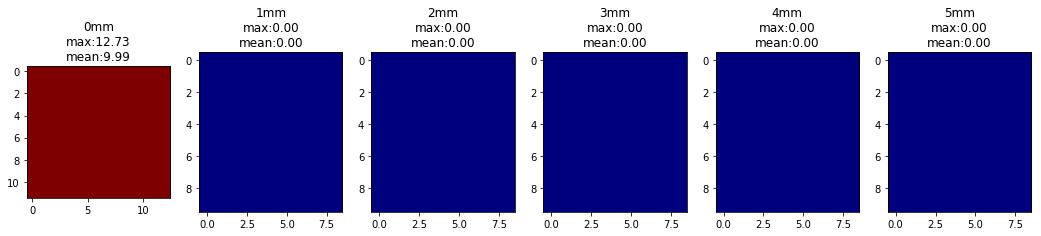

In [60]:
def maxmeanSUV(imgs,txt=0):
    maxSUV_list=[]
    meanSUV_list=[]
    if txt==1:
        print("imgs:",imgs.shape)
    fig=plt.figure(figsize=(18,6))
    for num in range(6):
        i=num
        ROI_cube=imgs[zR[i][0]:zR[i][1],yR[i][0]:yR[i][1],xR[i][0]:xR[i][1]]
        print(ROI_cube.shape)

        maxSUV=np.max(ROI_cube)

        pxl=2
        meanSUV=ROI_cube.mean()
        if txt==1:
            print("ROI_cube("+str(num)+"):",ROI_cube.shape)
            print("max:",maxSUV)
            print("mean:",meanSUV)
        ax=fig.add_subplot(1,6,num+1)
        ax.imshow(ROI_cube.max(axis=0),cmap="jet",vmin=0,vmax=8)
        ax.set_title("{}mm\nmax:{:.2f}\nmean:{:.2f}".format(num,maxSUV,meanSUV))
        maxSUV_list.append(maxSUV)
        meanSUV_list.append(meanSUV)
    return maxSUV_list, meanSUV_list


#ROI内のmaxSUVと球のmeanSUVを算出
# XYZ=[
#     [[102, 128], [133, 158], [30, 51]] ,
#     [[119, 138], [111, 129], [31, 50]] ,
#     [[149, 166], [112, 128], [33, 46]] ,
#     [[167, 178], [139, 149], [35, 47]] ,
#     [[154, 161], [165, 173], [37, 44]] ,
#     [[126, 132], [167, 173], [38, 44]] ]


imgs=imgs2mm
maxSUV_list_2mm, meanSUV_list_2mm=maxmeanSUV(imgs)
print("HR2mm")
plt.show()



In [42]:
print(xR)
print(yR)
print(zR)


[[307, 320], [11, 20], [21, 30], [31, 40], [41, 50], [51, 60]]
[[289, 296], [0, 10], [0, 10], [0, 10], [0, 10], [0, 10]]
[[68, 62], [11, 20], [21, 30], [31, 40], [41, 50], [51, 60]]


In [30]:
xR[0][0]=312
xR[0][1]=322

In [85]:
#保存用配列

#2D
# CSV_array=[]
# CSV_array.append(["size(mm)","2mm","4mm","pred_105NAnl","pred_105DAnl","pred_405NAnl","pred_405DAnl"])
# for k,v in MAX_SUV.items():
#     CSV_array.append([k,v[0],v[1],v[2],v[3],v[4],v[5]])
# print(CSV_array)


#3D
CSV_array=[]
CSV_array.append(["size(mm)","2mm","4mm","pred_405NAnl","pred_9_405NA"])
for k,v in MAX_SUV.items():
    CSV_array.append([k,v[0],v[1],v[2],v[3]])
print(CSV_array)

[['size(mm)', '2mm', '4mm', 'pred_405NAnl', 'pred_9_405NA'], [37, 8.230036984083574, 7.99332863817007, 8.20898, 8.160681], [28, 8.131013380868971, 7.9767049871533455, 8.015484, 8.025197], [22, 7.900503027911426, 7.970070461909837, 7.7890677, 7.989107], [17, 7.977267560488198, 7.972836599240283, 8.5386715, 8.2493515], [13, 7.490690361706011, 6.831183432223607, 8.142603, 8.233933], [10, 6.611783992516154, 4.725500033382535, 5.986646, 6.362078]]


In [86]:
import csv
os.chdir(r"C:\Users\endy4\SR_PET")
os.makedirs('suv',exist_ok=True)
with open('suv\\3D_SUV_2D40vs3D40.csv', 'w', newline="") as f:
    writer = csv.writer(f)
    writer.writerows(CSV_array)


In [85]:
#MEAN_SUV_1
ROI_NUM=0
CSV_NAME='suv\\3.5Mean105DA.csv'
b=3.5
print("border:",b)

# ROI_2mm_f=ROI_2mm[i].reshape(-1)
# ROI_4mm_f=ROI_4mm[i].reshape(-1)
# ROI_pred_f=ROI_pred[i].reshape(-1)


MEAN_2mm=np.zeros(6)
MEAN_4mm=np.zeros(6)
MEAN_pred=np.zeros(6)
count_pixel=np.zeros(6,int)
for i in range(nR):
    ROI_2mm_f=ROI_2mm[i].reshape(-1)
    ROI_4mm_f=ROI_4mm[i].reshape(-1)
    ROI_pred_f=ROI_pred[ROI_NUM][i].reshape(-1)
    ROI_2mm_b=[]
    ROI_4mm_b=[]
    ROI_pred_b=[]
    
    for j in range(len(ROI_2mm_f)):
        a=[ROI_2mm_f[j],ROI_4mm_f[j],ROI_pred_f[j]]
        if a[0]>=b:
            ROI_2mm_b.append(a[0])
            ROI_4mm_b.append(a[1])
            ROI_pred_b.append(a[2])

    MEAN_2mm[i]=np.mean(ROI_2mm_b)
    MEAN_4mm[i]=np.mean(ROI_4mm_b)
    MEAN_pred[i]=np.mean(ROI_pred_b)
    count_pixel[i]=int(len(ROI_2mm_b))
count_to_all=[str(count_pixel[i])+"/"+str(len(ROI_2mm[i].reshape(-1))) for i in range(len(count_pixel))]
print("BALL_size     38mm      28mm      22mm       17mm       13mm       10mm ")
print("MEAN_2mm",MEAN_2mm)
print("MEAN_4mm",MEAN_4mm)
print("MEAN_pred",MEAN_pred)
print("use_pixel",count_to_all)



border: 3.5
BALL_size     38mm      28mm      22mm       17mm       13mm       10mm 
MEAN_2mm [6.35275594 6.07430725 5.85585243 5.4367445  4.99875369 4.59431581]
MEAN_4mm [6.15240747 5.81401938 5.49865202 5.02800023 4.3088674  3.37568249]
MEAN_pred [6.37711334 6.08767176 5.85915184 5.41790676 4.82000923 4.07095194]
use_pixel ['3476/15444', '1455/7600', '660/4284', '290/1716', '116/576', '40/343']


In [86]:
print("しきい値:SUV=",b)
print("球直径","逆算した直径","球画素数/ROI画素数")
for i in range(len(count_pixel)):
    a=count_pixel[i]*(2**3)
    #a=4/3*(b/2)**3*pi
    R=(a/4)**(1/3)*2
    print(str(B_size[i])+"mm",R,count_to_all[i])

しきい値:SUV= 3.5
球直径 逆算した直径 球画素数/ROI画素数
37mm 38.17097472606489 3476/15444
28mm 28.553607934801818 1455/7600
22mm 21.93922620973047 660/4284
17mm 16.679101830805212 290/1716
13mm 12.289267302743388 116/576
10mm 8.617738760127533 40/343


In [84]:
#MEAN_SUV_2
MEAN_SUV={}
#B_size=[37,28,22,17,13,10]
print("ball_size","2mm","          4mm","             pred")
for i in range(nR):
    MEAN_SUV[B_size[i]]=[MEAN_2mm[i],MEAN_4mm[i],MEAN_pred[i]]
for k,v in MEAN_SUV.items():
    print(k,v)

ball_size 2mm           4mm              pred
37 [6.773884836843755, 6.551301779033121, 6.741222858428955]
28 [6.6455725200383595, 6.349646531908797, 6.604354381561279]
22 [6.43442114260271, 6.041455859443774, 6.399430274963379]
17 [6.233112436911719, 5.761343206719566, 6.0792741775512695]
13 [5.942227520898002, 5.145790364975569, 5.588311672210693]
10 [5.167786611324693, 3.8086098056607502, 4.484582424163818]


In [85]:
CSV_array=[]
CSV_array.append(["size(mm)","2mm","4mm","pred","pixel_num/pixel_all"])
i=0
for k,v in MEAN_SUV.items():
    CSV_array.append([k,v[0],v[1],v[2],count_to_all[i]])
    i+=1
    
print(CSV_array)

[['size(mm)', '2mm', '4mm', 'pred', 'pixel_num/pixel_all'], [37, 6.773884836843755, 6.551301779033121, 6.741222858428955, '3426/15444'], [28, 6.6455725200383595, 6.349646531908797, 6.604354381561279, '1425/7600'], [22, 6.43442114260271, 6.041455859443774, 6.399430274963379, '667/4284'], [17, 6.233112436911719, 5.761343206719566, 6.0792741775512695, '313/1716'], [13, 5.942227520898002, 5.145790364975569, 5.588311672210693, '127/576'], [10, 5.167786611324693, 3.8086098056607502, 4.484582424163818, '56/343']]


In [86]:
import csv

os.makedirs('suv',exist_ok=True)
with open(CSV_NAME, 'w', newline="") as f:
    writer = csv.writer(f)
    writer.writerows(CSV_array)

In [253]:
#MEAN_SUV_1(multi_pred)(未完成)
b=3
print("border:",b)

# ROI_2mm_f=ROI_2mm[i].reshape(-1)
# ROI_4mm_f=ROI_4mm[i].reshape(-1)
# ROI_pred_f=ROI_pred[i].reshape(-1)


MEAN_2mm=np.zeros(6)
MEAN_4mm=np.zeros(6)
MEAN_pred=[np.zeros(6) for i in range(len(ROI_pred))]
print(len(ROI_pred))
count_pixel=np.zeros(6,int)
for i in range(nR):
    ROI_2mm_f=ROI_2mm[i].reshape(-1)
    ROI_4mm_f=ROI_4mm[i].reshape(-1)
    ROI_pred_f_s=[ROI_pred[k][i].reshape(-1) for k in range(len(ROI_pred))]
    ROI_2mm_b=[]
    ROI_4mm_b=[]
    ROI_pred_b=[]
    
    for j in range(len(ROI_2mm_f)):
        a=[ROI_2mm_f[j],ROI_4mm_f[j],[ROI_pred_f_s[3][j]]]
        print(a)
        if a[0]>=b and a[1]>=b and min(a[2])>=b:
            ROI_2mm_b.append(a[0])
            ROI_4mm_b.append(a[1])
            ROI_pred_b.append(a[2])

    MEAN_2mm[i]=np.mean(ROI_2mm_b)
    MEAN_4mm[i]=np.mean(ROI_4mm_b)
    for k in range(len(ROI_pred_b)):
        print(ROI_pred_b[k])
        MEAN_pred[k][i]=np.mean(ROI_pred_b[k])
    count_pixel[i]=int(len(ROI_2mm_b))
count_to_all=[str(count_pixel[i])+"/"+str(len(ROI_2mm[i].reshape(-1))) for i in range(len(count_pixel))]
print("BALL_size     38mm      28mm      22mm       17mm       13mm       10mm ")
print("MEAN_2mm",MEAN_2mm)
print("MEAN_4mm",MEAN_4mm)
print("MEAN_pred",MEAN_pred)
print("use_pixel",count_to_all)



border: 3
4


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
#24pでROI切り取り
n=3
nR=6
ROI_2mm=[np.array([]) for i in range(nR)]
ROI_4mm=[np.array([]) for i in range(nR)]
ROI_pred=[np.array([]) for i in range(nR)]

imgL=[PH_2mm,PH_4mm_2,PH_pred_2]
print(np.max(imgL[0]),np.max(imgL[1]),np.max(imgL[2]))
for i in range(nR):
    ROI_2mm[i]=imgL[0][XYZ[i][2][0]:XYZ[i][2][1]+1,XYZ[i][1][0]:XYZ[i][1][1]+1,XYZ[i][0][0]:XYZ[i][0][1]+1]
    ROI_4mm[i]=imgL[1][XYZ[i][2][0]:XYZ[i][2][1]+1,XYZ[i][1][0]:XYZ[i][1][1]+1,XYZ[i][0][0]:XYZ[i][0][1]+1]
    ROI_pred[i]=imgL[2][XYZ[i][2][0]:XYZ[i][2][1]+1,XYZ[i][1][0]:XYZ[i][1][1]+1,XYZ[i][0][0]:XYZ[i][0][1]+1]

    
for i in range(nR):
    print(np.shape(ROI_2mm[i]),np.shape(ROI_4mm[i]),np.shape(ROI_pred[i]))
        
    
    
    

In [ ]:
#MAX_SUV
MAX_SUV={}
#B_size=[37,28,22,17,13,10]
print("ball_size","2mm","          4mm","             pred")
for i in range(nR):
    MAX_SUV[B_size[i]]=[np.max(ROI_2mm[i]),np.max(ROI_4mm[i]),np.max(ROI_pred[i])]
for k,v in MAX_SUV.items():
    print(k,v)

In [ ]:
print(MAX_SUV)

In [ ]:
CSV_array=[]
CSV_array.append(["size(mm)","2mm","4mm","pred"])
for k,v in MAX_SUV.items():
    CSV_array.append([k,v[0],v[1],v[2]])
print(CSV_array)
    

In [ ]:
import csv

os.makedirs('suv',exist_ok=True)
with open('suv\\3D_SUVH.csv', 'w', newline="") as f:
    writer = csv.writer(f)
    writer.writerows(CSV_array)


In [ ]:
print(os.getcwd())

In [ ]:
for i in range(nR):
    print(ROI_2mm[i],ROI_4mm[i],ROI_pred[i])
        

In [ ]:
#MSE
MSE_SUV={}
for i in range(nR):
    MSE_SUV[B_size[i]]=[np.mean((ROI_2mm[i].reshape(-1)-ROI_4mm[i].reshape(-1))**2),np.mean((ROI_2mm[i].reshape(-1)-ROI_pred[i].reshape(-1))**2)]
    MSE_24=ROI_2mm[i].reshape(-1)-ROI_4mm[i].reshape(-1)
    print(len(MSE_24),type(MSE_24[100]))
print(np.mean((PH_2mm.reshape(-1)-PH_4mm_2.reshape(-1))**2),np.mean((PH_2mm.reshape(-1)-PH_pred_2.reshape(-1))**2))
for k,v in MSE_SUV.items():
    print(k,v)

In [ ]:
#MSE
MSE_SUV={}
for i in range(nR):
    MSE_24=ROI_2mm[i].reshape(-1)-ROI_4mm[i].reshape(-1)
    MSE_2p=ROI_2mm[i].reshape(-1)-ROI_pred[i].reshape(-1)
    print(len(MSE_24),MSE_24[100])
    MSE_SUV[B_size[i]]=[np.mean((MSE_24)**2),np.mean((MSE_2p)**2)]
    
MSE_ALL=[np.mean((PH_2mm.reshape(-1)-PH_4mm_2.reshape(-1))**2),np.mean((PH_2mm.reshape(-1)-PH_pred_2.reshape(-1))**2)]
print(MSE_ALL)
print(np.max(PH_2mm),np.max(PH_pred))
#print("pixel_count",len(MSE_2p),"/",len(ROI_2mm_f),"sum:",np.sum(MSE_24),np.sum(MSE_2p))
for k,v in MSE_SUV.items():
    print(k,v)

In [ ]:
#MSE_border_on:閾値以下の画素を抜いて平均を計算
b=1
print("border:",b)
MSE_SUV={}
# ROI_2mm_f=ROI_2mm[i].reshape(-1)
# ROI_4mm_f=ROI_4mm[i].reshape(-1)
# ROI_pred_f=ROI_pred[i].reshape(-1)

for i in range(nR):
    ROI_2mm_f=ROI_2mm[i].reshape(-1)
    ROI_4mm_f=ROI_4mm[i].reshape(-1)
    ROI_pred_f=ROI_pred[0][i].reshape(-1)
    MSE_24=[]
    
    for j in range(len(ROI_2mm_f)):
        a=[ROI_2mm_f[j],ROI_4mm_f[j]]
        if a[0]>=b and a[1]>=b:
            MSE_24.append(a)
    MSE_24=np.array([i[0]-i[1] for i in MSE_24])
    #print(len(MSE_24),MSE_24[100])
    MSE_2p=[]
    for j in range(len(ROI_2mm_f)):
        a=[ROI_2mm_f[j],ROI_pred_f[j]]
        if a[0]>=b and a[1]>=b:
            MSE_2p.append(a)
    MSE_2p=np.array([i[0]-i[1] for i in MSE_2p])
    #print(len(MSE_2p),MSE_2p[100])
    print("pixel_count",len(MSE_2p),"/",len(ROI_2mm_f),"sum:",np.sum(MSE_2p))
    MSE_SUV[B_size[i]]=[np.mean((MSE_24)**2),np.mean((MSE_2p)**2)]

    
#すべての画素のMSE


ROI_2mm_f=PH_2mm.reshape(-1)
ROI_4mm_f=PH_4mm_2.reshape(-1)
ROI_pred_f=PH_pred_2.reshape(-1)
MSE_24=[]

for j in range(len(ROI_2mm_f)):
    a=[ROI_2mm_f[j],ROI_4mm_f[j]]
    if a[0]>=b and a[1]>=b:
        MSE_24.append(a)
MSE_24=np.array([i[0]-i[1] for i in MSE_24])
#print(len(MSE_24),MSE_24[100])
MSE_2p=[]
for j in range(len(ROI_2mm_f)):
    a=[ROI_2mm_f[j],ROI_pred_f[j]]
    if a[0]>=b and a[1]>=b:
        MSE_2p.append(a)
MSE_2p=np.array([i[0]-i[1] for i in MSE_2p])
#print(len(MSE_2p),MSE_2p[100])
print("pixel_count",len(MSE_2p),"/",len(ROI_2mm_f),"sum:",np.sum(MSE_24),np.sum(MSE_2p))
MSE_ALL=[np.mean((MSE_24)**2),np.mean((MSE_2p)**2)]
print("ALL",MSE_ALL,)
for k,v in MSE_SUV.items():
    print(k,v)
    

In [ ]:
MSE_ALL=[np.mean((PH_2mm[i]-PH_4mm_2[i])**2),np.mean((PH_2mm[i]-PH_pred_2[i])**2)]
print(MSE_ALL)

In [ ]:
ROI_2mm=[np.array([]) for i in range(nR)]
for i in range(nR):
    ROI_2mm[i]=PH_2mm[30:45,133:159,102:129]
for i in range(nR):
    print(np.shape(ROI_2mm[i]))

In [ ]:
print([XYZ[0][2][0],XYZ[i][2][1]+1],[XYZ[0][1][0],XYZ[0][1][1]+1],[XYZ[0][0][0],XYZ[0][0][1]+1])

In [ ]:
print(np.shape(XYZ))

In [ ]:
a=np.arange(24)
print(a)
b=a[9,8]
print(b)

In [ ]:
#MAX_SUV


In [ ]:
#frame12345

# windowを描画
root = tk.Tk()
# windowサイズを変更
root.geometry("1850x850")
# windowタイトルを設定
root.title("NEMA_PHANTOM")

#直方体を作る際の頂点の座標を表すグローバル変数
x1 = 0
x2 = 100
y1 = 0
y2 = 100
z1 = 0
z2 = 100
val1=41
val2=144
val3=144
#アキシャル画像
img1 = ImageTk.PhotoImage(PILImage.fromarray(PH_axi[int(val1)]))
frame1 = tk.Frame(root,width=700,height=1000)
canvas1 = tk.Canvas(frame1,width=288,height=288)
image_on_canvas1=canvas1.create_image(0,0,image=img1,tags="img1",anchor="nw")
#アキシャル上でスライス位置表示
canvas1.create_line(0, val2, len(PH_sag)-1, val2, fill='blue',tags="col")
canvas1.create_line(val3, 0, val3, len(PH_col)-1, fill='green',tags="sag")
#ROI長方形
canvas1.create_rectangle(x1,y1,x2,y2,outline="red",tags="rect")
#スケールバー
sc1 = tk.Scale(frame1,orient=tk.HORIZONTAL,length=250,from_=0,to=len(PH_axi)-1,command = img1_change)
canvas1.tag_bind("img1","<ButtonPress-1>",press_1)
canvas1.tag_bind("img1","<B1-Motion>",drag_1)
frame1.grid(row=0,column=0)
canvas1.grid(row=0,column=0)
sc1.grid(row=1)

#コロナル画像
img2 = ImageTk.PhotoImage(PIL.Image.fromarray(PH_col[int(val2)]))
frame2 = tk.Frame(root,width=700,height=1000)
canvas2 = tk.Canvas(frame2,width=288,height=288)
image_on_canvas2=canvas2.create_image(0,0,image=img2,tags="img2",anchor="nw")
#ROI長方形
canvas2.create_rectangle(x1,z1,x2,z2,outline="red",tags="rect2")
sc2 = tk.Scale(frame2,orient=tk.HORIZONTAL,length=250,from_=0,to=len(PH_col)-1,command = img2_change)
canvas2.tag_bind("img2","<ButtonPress-1>",press_2)
canvas2.tag_bind("img2","<B1-Motion>",drag_2)
frame2.grid(row=0,column=1)
canvas2.grid(row=0,column=0)
sc2.grid(row=1)

#サジタル画像
img3 = ImageTk.PhotoImage(PIL.Image.fromarray(PH_sag[int(val3)]))
frame3 = tk.Frame(root,width=700,height=1000)
canvas3 = tk.Canvas(frame3,width=288,height=288)
image_on_canvas3=canvas3.create_image(0,0,image=img3,tags="img3",anchor="nw")
#ROI長方形
canvas3.create_rectangle(y1,z1,y2,z2,outline="red",tags="rect3")
sc3 = tk.Scale(frame3,orient=tk.HORIZONTAL,length=250,from_=0,to=len(PH_sag)-1,command = img3_change)
frame3.grid(row=0,column=2)
canvas3.grid(row=0,column=0)
sc3.grid(row=1)

#統計量計算のボタン、信号の閾値を指定するscaleをつける
frame4 = tk.Frame(root,width=250,height=500)
frame4.grid(row=0,column=3)
btn = tk.Button(frame4,text="sta",command=ROI_select)
btn.grid(row=0,column=0)
bbn2 = tk.Button(frame4,text="mse")
bbn2.grid(row=1)
sc4 = tk.Scale(frame4,variable=tk.DoubleVar,orient=tk.VERTICAL,length=255,from_=0.0,to=100,resolution=0.1)
sc4.grid(row=2,column=0)
del_btn = tk.Button(frame4,text="clear",command=clear)
del_btn.grid(row=3,column=0)

#出力結果を表示する
frame5 = tk.Frame(root,width=250,height=500)
frame5.grid(row=0,column=4)
text_widget = tk.Text(frame5,width=50,height=30)
text_widget.grid(row=0,column=0)
scroll = tk.Scrollbar(frame5,orient=tk.VERTICAL,command=text_widget.yview)
scroll.grid(row=0,column=1,sticky="NSW",rowspan=2)
text_widget["yscrollcommand"]=scroll.set
    
ROI37=[str(x1),str(x2),str(y1),str(y2),str(z1),str(z2)]
text_widget.insert("1.0",str(ROI37))

root.mainloop()

In [36]:
#frame123
# windowを描画
root = tk.Tk()
# windowサイズを変更
root.geometry("1850x850")
# windowタイトルを設定
root.title("NEMA_PHANTOM")

#直方体を作る際の頂点の座標を表すグローバル変数
x1 = 0
x2 = 100
y1 = 0
y2 = 100
z1 = 0
z2 = 100
val1=41
val2=144
val3=144
#アキシャル画像
img1 = ImageTk.PhotoImage(PIL.Image.fromarray(PH_axi[int(val1)]))
frame1 = tk.Frame(root,width=700,height=1000)
canvas1 = tk.Canvas(frame1,width=288,height=288)
image_on_canvas1=canvas1.create_image(0,0,image=img1,tags="img1",anchor="nw")
# #アキシャル上でスライス位置表示
# canvas1.create_line(0, val2, len(PH_sag)-1, val2, fill='blue',tags="col")
# canvas1.create_line(val3, 0, val3, len(PH_col)-1, fill='green',tags="sag")
#ROI長方形
canvas1.create_rectangle(x1,y1,x2,y2,outline="red",tags="rect")
#スケールバー
sc1 = tk.Scale(frame1,orient=tk.HORIZONTAL,length=250,from_=0,to=len(PH_axi)-1,command = img1_change)
canvas1.tag_bind("img1","<ButtonPress-1>",press_1)
canvas1.tag_bind("img1","<B1-Motion>",drag_1)
frame1.grid(row=0,column=0)
canvas1.grid(row=0,column=0)
sc1.grid(row=1)

# #コロナル画像
# img2 = ImageTk.PhotoImage(PIL.Image.fromarray(PH_col[int(val2)]))
# frame2 = tk.Frame(root,width=700,height=1000)
# canvas2 = tk.Canvas(frame2,width=288,height=288)
# image_on_canvas2=canvas2.create_image(0,0,image=img2,tags="img2",anchor="nw")
# #ROI長方形
# canvas2.create_rectangle(x1,z1,x2,z2,outline="red",tags="rect2")
# sc2 = tk.Scale(frame2,orient=tk.HORIZONTAL,length=250,from_=0,to=len(PH_col)-1,command = img2_change)
# canvas2.tag_bind("img2","<ButtonPress-1>",press_2)
# canvas2.tag_bind("img2","<B1-Motion>",drag_2)
# frame2.grid(row=0,column=1)
# canvas2.grid(row=0,column=0)
# sc2.grid(row=1)

# #サジタル画像
# img3 = ImageTk.PhotoImage(PIL.Image.fromarray(PH_sag[int(val3)]))
# frame3 = tk.Frame(root,width=700,height=1000)
# canvas3 = tk.Canvas(frame3,width=288,height=288)
# image_on_canvas3=canvas3.create_image(0,0,image=img3,tags="img3",anchor="nw")
# #ROI長方形
# canvas3.create_rectangle(y1,z1,y2,z2,outline="red",tags="rect3")
# sc3 = tk.Scale(frame3,orient=tk.HORIZONTAL,length=250,from_=0,to=len(PH_sag)-1,command = img3_change)
# frame3.grid(row=0,column=2)
# canvas3.grid(row=0,column=0)
# sc3.grid(row=1)

root.mainloop()

print(x1,x2,y1,y2)

0 100 0 100


In [ ]:
a1=1
a2=2
a3=3


In [35]:
root.mainloop()